<img style="float: left;" src="images/EP_Logo.png" alt="UoE" width="300px"/>
<img style="float: right;" src="images/UoE_Logo.png" alt="UoE" width="300px"/>
<img style="float: center;" src="images/urban_rural_scape.png" alt="urban" width="1100px"/>

# Modelling emissions from road traffic
<img style="float: right;" src="images/car-exhaust.png" alt="smoky car" width="240px"/></p>
 
Jupyter notebook for ECSC09005 Environmental Pollution  
author: John Moncrieff *for* Session 2020-21  [version 0.14, latest 11:06, 1 Feb 2021]
## Background
Modelling polutant dispersal from fixed point and area sources by the gaussian plume model is obvious but how do we model vehicle emissions from traffic flowing along a road? We just adapt the gaussian plume model by effectively replicating point sources along the roadway and running individual gaussian plume models at each of these points. This is known as a line source model. In this exercise, we will use a line source model called *RLine* from  the US Environmnental Protection Agency. This model has been well used for many years and is used for all sorts of regulatory purposes in the USA. You can read more about RLine at the US EPA's web site - https://www.cmascenter.org/r-line/. You used the UK's DMRB screening model to look at traffic emissions; RLINE is a step up in complexity and realism.

What I want you to get out of RLine is an appreciation for how emissions from the vehicle fleet is influenced by wind speed, atmospheric stability and wind direction and how that dictates local air quality.

## Imports
Let's start by importing some libraries to the environment:
- *matplotlib inline* for creating inline plots
- *pandas* to order and sort data in a convenient Table-like format
- *numpy* for numerical routines
- *matplotlib* for plotting data
- *scipy* for interploation routines
- *tqdm* for timing progress bar 
- *subprocess* so we can run RLine which is written in FORTRAN
- *ipywidgets* for interactivity
- *src* for python code that just takes up space in the main notebook

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import matplotlib.gridspec as gridspec
import sys
import math
import tqdm as tqdm
import subprocess
import os, csv
from datetime import datetime
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import HBox, Label
from src import efbvt, pls, ytv
from src.reftinterface import reftinterface
print('Imports loaded - continue')

Imports loaded - continue


## Step 1: Get the emissions inventory

As we discussed in the lecture series, we need 3 pieces of information to perform a dispersion modelling exercise: weather conditions, an emissions inventory and a dispersion model. <img style="float: right;" src="images/dm.png" alt="dispersion model process" width="450px"/></p>In this exercise, we'll just assume 4 different atmospheric stabilities and use a dispersion model called RLINE which models emissions from traffic. The emissions inventory we will use is derived from vehicle tests under different traffic scenarios and on different road types. It can get a bit complicated to come up with vehicle emissions that are then fed into the dispersion model. <br/><br/>We use a methodology which has been well-documented. I'll give you a flavour of what is involved but the detail can be a bit overwhelming - quite often users in the UK use an Excel-based system called the 'Emissions Factor Toolkit' (https://laqm.defra.gov.uk/review-and-assessment/tools/emissions-factors-toolkit.html and operates rather like the DMRB screening model you used in the practical exercise) but we've found that this no longer seems to be compatible with macs (at least in GeoSciences - it works on Windows PCs) in particular so I've coded it up into python for this exercise (my python code is imported here but if you want to view it, its in the file you downloaded from GitHub).

The total emission factors ($EF_i$) and traffic activity ($A_i$) inputs are combined to create hourly emissions, ($E_i$) for each roadlink ($i$) in the area we are modelling.
$E_i = EF_i \ A_i \tag{1} $
> where:    
$E F_i = \sum_{vehclass} ef_i (pollutant, speed, month, temp) \ fleetmix(vehclass) \tag{2}$<br/><br/>
$A_i = AADT_i \ TAF_i (hour, day, month) \tag{3} $


The concentration ($C$) at any location is given by $C = \sum_i E_i \ X_i \ \tag{4}$ where $X_i$ is the dispersion from each road link, $i$ to each receptor generated by RLINE with unit emission rate. $AADT_i$ is the annual average daily traffic; $TAF_i$ is the Temporal Allocation Factor ie congestion. 

### Sources of emission data for vehicles

In the EU, testing and reporting of vehicle emissions is reported via a service known as COPERT - the DMRB model you used previously uses data from COPERT as input for its calculations (in DMRB you just don't see this level of detail since its a screening model after all). COPERT produces spreadsheets of emission data for >60  vehicle types in Europe and these sheets are organised by vehicle sector (eg passenger cars, articulated lorries, buses etc) and emisisons are given in terms of a polynomial fit to measured emissions tests as a function of speed. Equation 5 below is such an equation. For this model, I've taken one of the COPERT spreadsheets that refers to 2020 emissions and coded the emissions as a function of vehicle type and vehicle speed. This creates the emission inventory we then feed into the RLINE model. The link to COPERT if you want to follow any of this for yourself (and its NOT required for this exercise) is https://www.emisia.com/utilities/copert/  <br></br>
Equation 5 is the polynomial fit for all vehicle types (where $\alpha, \beta, \gamma, \delta, \epsilon, \zeta$ and $\eta$ are different for each vehicle type and $v$ is the vehicle speed (in the range 10 to 130 km/h). RF is an adjustment factor, usually small.

$EF = \Large \frac{(\alpha v^2 + \beta v + \gamma + \delta /v)}{(\epsilon v^2 + \zeta v + \eta)} \large (1-RF) \tag{5}$

<details>  
<summary markdown="span">If you REALLY want to see what a tiny part of one of the input spreadsheets to this program is, click to expand!</summary>
    
<div class="alert alert-block alert-info">
    
|    Category    |  Fuel  |       Segment       | Euro Standard | Technology |  Pollutant |      Mode      | Min Speed [km/h] | Max Speed [km/h] |    Alpha   |    Beta    |    Gamma   |    Delta   |   Epsilon  |    Zita    |     Hta    | Reduction Factor [%] | Bio Reduction Factor [%] | 15 | EF [g/km] or ECF [MJ/km] |
|:--------------:|:------:|:-------------------:|:-------------:|:----------:|:----------:|:--------------:|:----------------:|:----------------:|:----------:|:----------:|:----------:|:----------:|:----------:|:----------:|:----------:|:--------------------:|:------------------------:|:--:|:------------------------:|
| Passenger Cars | Petrol | Large-SUV-Executive | Euro 4        | GDI        | PM Exhaust | Urban Peak     | 10               | 130              | 0          | 0          | 0.00128    | 0          | 0          | 0          | 1          | 0                    | 0                        | 15 | 0.00128                  |
| Passenger Cars | Petrol | Large-SUV-Executive | Euro 4        | GDI        | PM Exhaust | Urban Off Peak | 10               | 130              | 0          | 0          | 0.00128    | 0          | 0          | 0          | 1          | 0                    | 0                        | 15 | 0.00128                  |
| Passenger Cars | Petrol | Large-SUV-Executive | Euro 4        | GDI        | PM Exhaust | Rural          | 10               | 130              | 0          | 0          | 0.000836   | 0          | 0          | 0          | 1          | 0                    | 0                        | 15 | 0.000836                 |
| Passenger Cars | Petrol | Large-SUV-Executive | Euro 4        | GDI        | PM Exhaust | Highway        | 10               | 130              | 0          | 0          | 0.00119    | 0          | 0          | 0          | 1          | 0                    | 0                        | 15 | 0.00119                  |
| Passenger Cars | Petrol | Large-SUV-Executive | Euro 4        | PFI        | PM Exhaust | Urban Peak     | 10               | 130              | 0          | 0          | 0.00128    | 0          | 0          | 0          | 1          | 0                    | 0                        | 15 | 0.00128                  |
| Passenger Cars | Petrol | Large-SUV-Executive | Euro 4        | PFI        | PM Exhaust | Urban Off Peak | 10               | 130              | 0          | 0          | 0.00128    | 0          | 0          | 0          | 1          | 0                    | 0                        | 15 | 0.00128                  |
| Passenger Cars | Petrol | Large-SUV-Executive | Euro 4        | PFI        | PM Exhaust | Rural          | 10               | 130              | 0          | 0          | 0.000836   | 0          | 0          | 0          | 1          | 0                    | 0                        | 15 | 0.000836                 |
| Passenger Cars | Petrol | Large-SUV-Executive | Euro 4        | PFI        | PM Exhaust | Highway        | 10               | 130              | 0          | 0          | 0.00119    | 0          | 0          | 0          | 1          | 0                    | 0                        | 15 | 0.00119                  |
| Passenger Cars | Petrol | Large-SUV-Executive | Euro 5        | GDI        | PM Exhaust |                | 10               | 130              | 5.7274E-07 | -0.0001259 | 0.00690719 | 0.06422941 | 0.00032976 | -0.0877664 | 6.01192129 | 0                    | 0                        | 15 | 0.00197701               |
| Passenger Cars | Petrol | Large-SUV-Executive | Euro 5        | PFI        | PM Exhaust |                | 10               | 130              | 5.7274E-07 | -0.0001259 | 0.00690719 | 0.06422941 | 0.00032976 | -0.0877664 | 6.01192129 | 0                    | 0                        | 15 | 0.00197701               |
| Passenger Cars | Petrol | Large-SUV-Executive | Euro 6 a/b/c  | GDI        | PM Exhaust |                | 10               | 130              | 7.3573E-07 | -0.0001581 | 0.00928471 | 0.04108643 | 0.00026877 | -0.077925  | 6.02105323 | 0                    | 0                        | 15 | 0.00199838               |
| Passenger Cars | Petrol | Large-SUV-Executive | Euro 6 a/b/c  | PFI        | PM Exhaust |                | 10               | 130              | 7.3573E-07 | -0.0001581 | 0.00928471 | 0.04108643 | 0.00026877 | -0.077925  | 6.02105323 | 0                    | 0                        | 15 | 0.00199838               |
| Passenger Cars | Petrol | Large-SUV-Executive | Euro 6 d-temp | GDI        | PM Exhaust |                | 10               | 130              | 5.5963E-07 | -0.0001169 | 0.00745951 | 0.00740175 | 9.3328E-05 | -0.0348877 | 3.5051065  | 0.5                  | 0                        | 15 | 0.00105318               |
| Passenger Cars | Petrol | Large-SUV-Executive | Euro 6 d-temp | PFI        | PM Exhaust |                | 10               | 130              | 5.5963E-07 | -0.0001169 | 0.00745951 | 0.00740175 | 9.3328E-05 | -0.0348877 | 3.5051065  | 0.5                  | 0                        | 15 | 0.00105318               |
| Passenger Cars | Petrol | Large-SUV-Executive | Euro 6 d      | GDI        | PM Exhaust |                | 10               | 130              | 5.5963E-07 | -0.0001169 | 0.00745951 | 0.00740175 | 9.3328E-05 | -0.0348877 | 3.5051065  | 0.5                  | 0                        | 15 | 0.00105318               |
| Passenger Cars | Petrol | Large-SUV-Executive | Euro 6 d      | PFI        | PM Exhaust |                | 10               | 130              | 5.5963E-07 | -0.0001169 | 0.00745951 | 0.00740175 | 9.3328E-05 | -0.0348877 | 3.5051065  | 0.5                  | 0                        | 15 | 0.00105318               |
| Passenger Cars | Diesel | Large-SUV-Executive | Euro 4        | DPF        | PM Exhaust |                | 10               | 130              | 1.1723E-05 | -0.0018157 | 0.15159145 | 2.443E-14  | -4.455E-18 | -3.28E-15  | 3.36869884 | 0                    | 0                        | 15 | 0.037698                 |
| Passenger Cars | Diesel | Large-SUV-Executive | Euro 5        | DPF        | PM Exhaust |                | 10               | 130              | -2.689E-07 | 7.5661E-05 | 0.02388406 | 0.08265939 | -0.000608  | 0.21145386 | 4.45558199 | 0                    | 0                        | 15 | 0.00406765               |
| Passenger Cars | Diesel | Large-SUV-Executive | Euro 6 a/b/c  | DPF        | PM Exhaust |                | 10               | 130              | 0.0004673  | 0.0664095  | -0.3250106 | 0.96076264 | 1.13723866 | 0.54617955 | 0.28963315 | 0                    | 0                        | 15 | 0.0031787                |
| Passenger Cars | Diesel | Large-SUV-Executive | Euro 6 d-temp | DPF        | PM Exhaust |                | 10               | 130              | 0.0004673  | 0.0664095  | -0.3250106 | 0.96076264 | 1.13723866 | 0.54617955 | 0.28963315 | 0                    | 0                        | 15 | 0.0031787                |
| Passenger Cars | Diesel | Large-SUV-Executive | Euro 6 d      | DPF        | PM Exhaust |                | 10               | 130              | 0.0004673  | 0.0664095  | -0.3250106 | 0.96076264 | 1.13723866 | 0.54617955 | 0.28963315 | 0                    | 0                        | 15 | 0.0031787                |
    </div>  
 </details>

As far as I can tell, COPERT does some vehicle emission testing itself but testing vehicles for emissions is a regular part of motor manufacturing and maintenance. While some of it has a dodgy past (think dieselgate from VW https://www.telegraph.co.uk/finance/newsbysector/industry/11906842/Five-questions-about-the-VW-emissions-scandal-that-wont-go-away.html), there are more safeguards in place now. This is quite a nice read from a personal viewpoint by one 'concerned BBC journalist': https://www.bbc.co.uk/news/resources/idt-sh/how_toxic_is_your_car_exhaust
<img style="float: right;" src="images/mira.png" alt="emissions testing" width="360px"/></p>

### What we're going to do
We're going to find all the terms in Equation 1 above to derive the emission factor $E_i$ for our default road system (the simple two intersecting roadways I mentioned earlier).  
We'll find the total emissions factor $E F_i$ as a function of all the vehicle types in the COPERT database for PM and NOx using Equation 5.  
Next we'll estimate how busy our road system is (you'll enter a number for $AADT$ and time of day (to take trffic congestion into account).  
We then feed $E_i$ into RLINE and RLINE then calculates the ground-level concentration of PM and NOx at many different receptor sites.  That's all there is to it!  You can then do sensitivity analysis by changing eg the number of vehicles ($AADT$) on the road o the types of vehicle in the fleet mix (eg what would happen if petrol/diesel cars were largely abandined in favour of electric vehicles?).

In [2]:
# Create some selection boxes for the vehicle fleetmix
fd = reftinterface()             # the view Class in MVC parlance effectively
#print(fd.fleetmix_2020)         # just check its all there
widgets.VBox(children=[fd.h1,fd.h2,fd.h3,fd.h4])

In [3]:
print(fd.fleetmix_2020)   
# I like to print this out just to check all the input data is correct

{'electric': 0.5, 'petrol': 47.8, 'diesel': 33.1, 'petrol_lgv': 0.4, 'diesel_lgv': 15.0, 'rigid': 0.9, 'artic': 0.4, 'biodiesel': 0.1, 'buses': 0.7, 'motorcycle': 0.9, 'lpg': 0.2}


In [4]:
# ... and some selection boxes for traffic conditions
widgets.HBox([fd.bft_AADT, fd.bft_vs, fd.bft_hour])

In [32]:
# This cell actually calculates the emission inventory for any road taking
# into account the % type of vehicles in the mix, the congestion,
# traffic count, hour of day and average vehicle speed. SO - if you change
# any of these options above (and you need to for this exercise), 
#
# YOU NEED TO RE-RUN THIS CELL WHEN YOU CHANGE ANY OF THE INPUT DATA 

hwpme,hwnxe,traffic_count = efbvt.efbvt(fd.fleetmix_2020, fd.trafficstats, fd.TomTom_congestion)

# Returns PM and NOx emission in units of g/m/s ready for input to RLINE
# It does take a few seconds to run so be patient.

# You'll see 3 lines of text output when the cell completes
# The first line just confirms the traffic data you entered
# The other two lines are the emission factor for PM and NOx for the road conditions
# taking into account the fleetmix you chose earlier.

Traffic count = 71000  per day, Vehicle speed = 15 km/h, Time of day = 18
PM Emission (g/m/s) =  [2.94565105e-05]
NOx Emission (g/m/s) =  [0.00262632]


## Step 2: RUN the model
Let's run these emissions through the model for 4 different conditions of atmospheric stability: very stable, stable, neutral and unstable. We're going to model the ground-level concentration (glc) across a 100 x 100 m domain with two main roads running at right angles to one another (in practice, you can have any geometry as we'll see later). <img style="float: right;" src="images/ED3_site_st_leonards.png" alt="St Leonards" width="300px"/></p>I've chosen to output glc's for PM and NOx at 4 sites, each within 20 m of the main intersection - to replicate what you might expect at say the St Leonard's monitoring site in Edinburgh,<img style="float: right;" src="images/ED1_site_st_johns_road.png" alt="St John Road" width="300px"/></p> rather than the site next to St John's Road in Edinburgh which is right on the pavement. (Have a look at Lecture 3 to see results from the commercial ADMS model and how quickly glc drops off from the road).


In [33]:
print("Click to run RLINE with the folllowing inputs: ",fd.trafficstats)
print("It'll take a few seconds to run then you'll see a message to proceed to the next cell")
display(fd.btn)

Click to run RLINE with the folllowing inputs:  {'AADT': 71000, 'hour': 18, 'vs': 15}
It'll take a few seconds to run then you'll see a message to proceed to the next cell


Button(description='Run RLINE', style=ButtonStyle(button_color='tomato'))

running RLINE ...
Run complete - goto next cell


## Step 3: PLOT the results

stable
              PM        NOx
site 1  [107.53]  [9587.24]
site 2   [58.35]  [5202.04]
site 3    [9.12]   [813.11]
site 4   [58.31]  [5198.58]


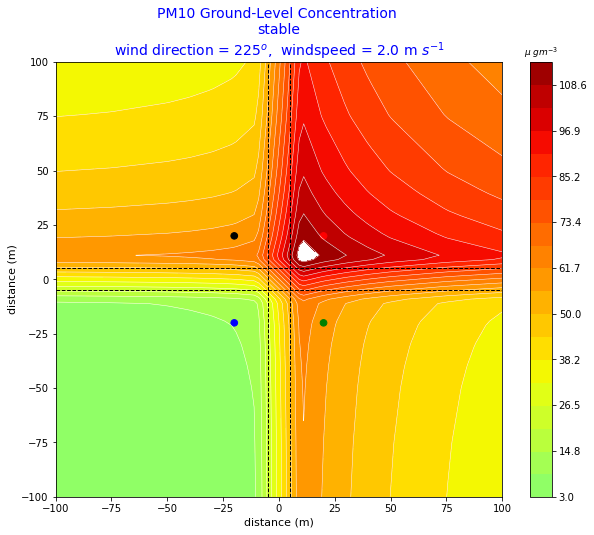

-----------------------------------------------------
weakly stable
             PM        NOx
site 1  [38.18]  [3404.12]
site 2  [21.09]  [1879.99]
site 3   [3.99]    [355.6]
site 4  [21.08]  [1879.71]


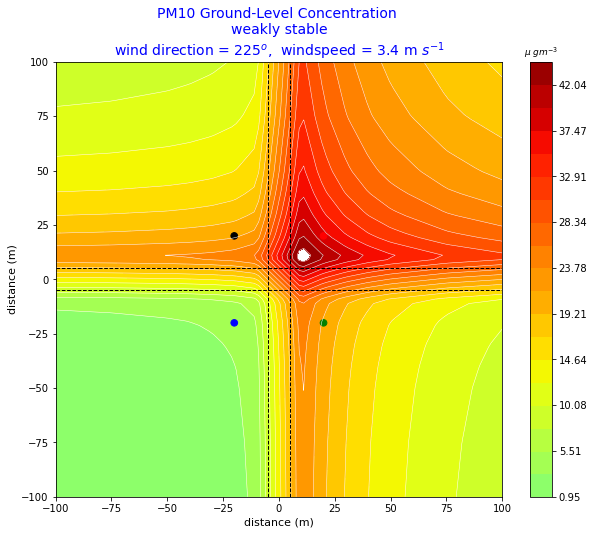

-----------------------------------------------------
weakly convective
             PM        NOx
site 1  [35.59]  [3172.77]
site 2  [20.54]  [1831.41]
site 3    [5.5]   [490.28]
site 4  [20.54]   [1831.5]


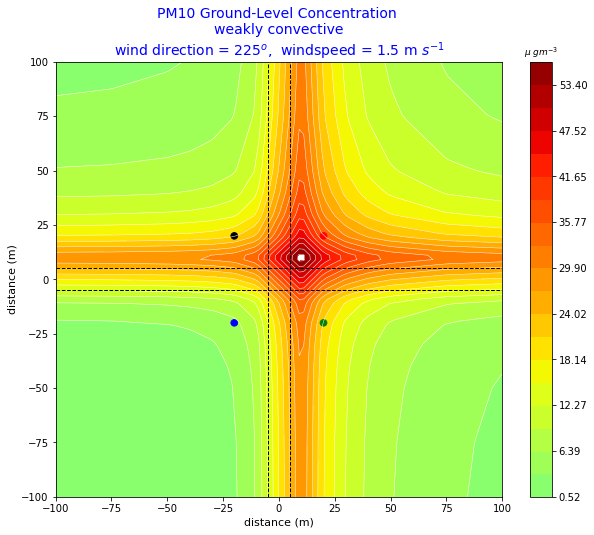

-----------------------------------------------------
convective
            PM        NOx
site 1  [14.1]  [1257.36]
site 2  [7.65]    [681.8]
site 3  [1.19]   [106.52]
site 4  [7.65]   [682.13]


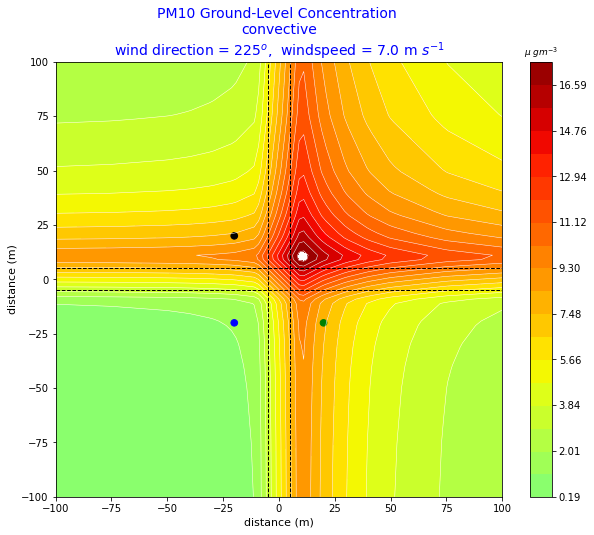

-----------------------------------------------------


In [34]:
#rplot.plotrw()
sites = []
max = min = 0
gs = gridspec.GridSpec(4, 4)
gs.update(left=0.10, right=0.95, hspace=0.05)
hourly_stab = ['stable','weakly stable','weakly convective','convective']
sitenames = ['site 1','site 2','site 3','site 4']
infilename = 'Output_Example_Numerical.csv'
infilename2 = 'Met_Example.csv'   
# use Pandas to read in concentration data
dfc=pd.read_csv(infilename, header=10, skipinitialspace=True)
#print(dfc)
# use Pandas to read in meteorology data
dfm=pd.read_csv(infilename2, skip_blank_lines=True, skipinitialspace=True)
#dfm.head(4)
# NB - RLINE has calculated the concentrations based on unit emission
# so we need to multiply the predicted concentrations by the actual emissions
hourlist=[]
methourlist=[]
# Split into hourly dataframes for graphing
# https://stackoverflow.com/questions/54046707/pandas-split-one-dataframe-into-multiple-dataframes
for h in dfc['Hour'].unique():
    temp = 'dfc_{}'.format(h)
    #hourlist.append(temp)  # keep track of data files to process
    vars()[temp] = dfc[dfc['Hour']==h]

hourlist=[dfc_1, dfc_2, dfc_3, dfc_4]

for h in dfm['Hour'].unique():
    temp = 'dfm_{}'.format(h)  
    vars()[temp] = dfm[dfm['Hour']==h]

methourlist=[dfm_1, dfm_2, dfm_3, dfm_4]

i=0 
# extract the x, y, z-values to 1-D arrays for plotting
xx = dfc_1['X-Coordinate'].to_numpy()
yy = dfc_1['Y-Coordinate'].to_numpy()
siteinfo = pd.DataFrame(sitenames)
path = './results'
for dfhn in hourlist:
    dfh = pd.DataFrame(dfhn)
    hour=i
    stab=hourly_stab[i]
    print(stab)
    # Particulate matter
    zzp = (dfh['C_G1']*hwpme+dfh['C_G2']*hwpme).to_numpy()
    # NOx
    zzn = (dfh['C_G1']*hwnxe+dfh['C_G2']*hwnxe).to_numpy()

    max = (dfh['C_G1']*hwpme+dfh['C_G2']*hwpme).max()
    min = (dfh['C_G1']*hwpme+dfh['C_G2']*hwpme).min()

    # get the concentration values at the 4 receptor sites
    dfs1 = dfh[((dfh['X-Coordinate'] == 20.000) & (dfh['Y-Coordinate'] == 20.000))]
    dfs2 = dfh[((dfh['X-Coordinate'] == 20.000) & (dfh['Y-Coordinate'] == -20.000))]
    dfs3 = dfh[((dfh['X-Coordinate'] == -20.000) & (dfh['Y-Coordinate'] == -20.000))]
    dfs4 = dfh[((dfh['X-Coordinate'] == -20.000) & (dfh['Y-Coordinate'] == 20.000))]
    # Get the concentration values at the 4 receptor sites
    # Particulates first
    s1zp = dfs1.iloc[0]['C_G1']*hwpme+dfs1.iloc[0]['C_G2']*hwpme
    s2zp = dfs2.iloc[0]['C_G1']*hwpme+dfs2.iloc[0]['C_G2']*hwpme
    s3zp = dfs3.iloc[0]['C_G1']*hwpme+dfs3.iloc[0]['C_G2']*hwpme
    s4zp = dfs4.iloc[0]['C_G1']*hwpme+dfs4.iloc[0]['C_G2']*hwpme
    # Next NOx
    s1zn = dfs1.iloc[0]['C_G1']*hwnxe+dfs1.iloc[0]['C_G2']*hwnxe
    s2zn = dfs2.iloc[0]['C_G1']*hwnxe+dfs2.iloc[0]['C_G2']*hwnxe
    s3zn = dfs3.iloc[0]['C_G1']*hwnxe+dfs3.iloc[0]['C_G2']*hwnxe
    s4zn = dfs4.iloc[0]['C_G1']*hwnxe+dfs4.iloc[0]['C_G2']*hwnxe
    
    sitesp = [s1zp, s2zp, s3zp, s4zp]
    sitesn = [s1zn, s2zn, s3zn, s4zn]
    # Put the Conc data into a Pandas DataFrame so you can display it
    siteinfo = pd.DataFrame(index=sitenames)
    siteinfo['PM'] = sitesp
    siteinfo['NOx'] = sitesn
    siteinfo['PM'] = pd.Series([np.round(val, 2) for val in siteinfo['PM']], index = siteinfo.index)
    siteinfo['NOx'] = pd.Series([np.round(val, 2) for val in siteinfo['NOx']], index = siteinfo.index)
    print(siteinfo)
    # pass to plotting routine
    pls.pls(gs, xx, yy, zzp, hour, min, max, methourlist[i], sitesp, sitesn, stab)
    i=i+1
    print('-----------------------------------------------------')
    now = datetime.now()    # datetime object containing current date and time
    # print("now =", now)
    dt_string = now.strftime("%Y%m%d_%H%M%S")  # YY/mm/dd_H:M:S
    file1 = os.path.join(path,"output.csv")
    with open(file1, 'a') as f_object:
        writer_object = csv.writer(f_object)
        fields = [dt_string,stab,fd.trafficstats["AADT"],fd.trafficstats["hour"],fd.trafficstats["vs"],
                    str(hwpme)[1:-1],str(s1zp)[1:-1],str(s2zp)[1:-1],str(s3zp)[1:-1],str(s4zp)[1:-1],
                    str(hwnxe)[1:-1],str(s1zn)[1:-1],str(s2zn)[1:-1],str(s3zn)[1:-1],str(s4zn)[1:-1]]
        writer_object.writerow(fields)
        f_object.close()
    
    


You'll notice the dispersion patterns look similar since wind direction largely controls the pullutant here given the source height (the vehicle exhaust is low and similar'ish acrosss the vehicle fleet). The actual values of ground-level concentration do vary markedly of course in the different stability conditions.

RLINE has been developed by the US Environmental Protection Agency to investigate air quality near roads. There is a web-based version - called CLINE - which runs for much of the whole of the USA (not the Rest of the World unfortunately) but these web pages show just how powerful a tool CLINE is: https://www.cmascenter.org/c-tools/

In [ ]:
ytv.display_yotube_video("https://youtu.be/iY-PBXd_0sM", width=800, height=600)
# If you have any trouble watching this youtube video, you can go to it directly: 
# https://www.cmascenter.org/c-tools/ 

<img style="float: center;" src="images/urban_rural_scape.png" alt="urban" width="1100px"/>

# END